In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from plot_functions import *
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [16]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [17]:
n_splits = 10
import sys
case=2
a=2
cost='abs'

In [18]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [19]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [20]:
from sklearn.model_selection import train_test_split, KFold

In [21]:
tensor = get_tensor(df, dfc)
H, A, T = learn_HAT(case, tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)


In [22]:
home_fac = pd.DataFrame(H, index=df.index, columns=['HF_0', 'HF_1'])

In [23]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in xrange(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids, random_state=0)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1, random_state=0)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [24]:
num_clusters = 2
labels_hf, centroids_2, X_hat = kmeans_missing(home_fac[['HF_0', 'HF_1']], n_clusters=num_clusters)
home_fac['labels_hf'] = labels_hf



for appliance in APPLIANCES_ORDER:

    appliance_df = df[['%s_%d' %(appliance, month) for month in range(1, 13)]]
    labels, centroids, X_hat = kmeans_missing(df[['%s_%d' %(appliance, month) for month in range(1, 13)]], n_clusters=num_clusters)


    accuracy_reg = accuracy_score(labels, labels_hf)
    accuracy_inv = accuracy_score(1-labels, labels_hf)
    print(appliance, max(accuracy_reg, accuracy_inv))
    if accuracy_inv>accuracy_reg:
        labels=1-labels
    home_fac['labels_%s' %appliance] = labels

/Users/nipunbatra/anaconda2/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


('aggregate', 0.97435897435897434)
('hvac', 1.0)
('fridge', 0.76923076923076927)
('mw', 0.71794871794871795)
('dw', 0.76923076923076927)
('wm', 0.66666666666666663)
('oven', 0.69230769230769229)


In [25]:
def annotate_df(row):  
    ax.annotate(row.name, row.values,
                xytext=(10,-5), 
                textcoords='offset points',
                size=18, 
                color='darkslategrey')

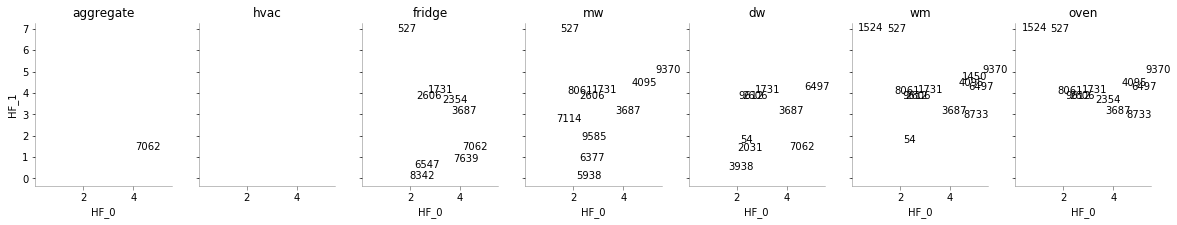

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=7, sharex=True, sharey=True, figsize=(20, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    
    appliance_mis_df = home_fac.query('labels_hf!=labels_%s' %appliance)
    if len(appliance_mis_df):
        appliance_mis_df.plot('HF_0', 'HF_1', kind='scatter', s=0,  ax=ax[i],
                             color=tableau20blind[1],  )
        for k, v in appliance_mis_df.iterrows():
            
            ax[i].annotate(k, xy = (v['HF_0'], v['HF_1']),
                        xytext=(0, 0), textcoords='offset points',
                        family='sans-serif', fontsize=10, color='black')
    format_axes(ax[i])  
    ax[i].set_title(appliance)
    


    

In [32]:
df.loc[1524]

hvac_1                     NaN
hvac_2                     NaN
hvac_3                     NaN
hvac_4                     NaN
hvac_5                     NaN
hvac_6                     NaN
hvac_7                     NaN
hvac_8              546.411072
hvac_9              545.248230
hvac_10             174.709518
hvac_11               0.029933
hvac_12               0.048017
wm_1                       NaN
wm_2                       NaN
wm_3                       NaN
wm_4                       NaN
wm_5                       NaN
wm_6                       NaN
wm_7                       NaN
wm_8                       NaN
wm_9                       NaN
wm_10                      NaN
wm_11                      NaN
wm_12                      NaN
fridge_1                   NaN
fridge_2                   NaN
fridge_3                   NaN
fridge_4                   NaN
fridge_5                   NaN
fridge_6                   NaN
                      ...     
dw_3                       NaN
dw_4    

In [71]:
df.ix[527].dropna()

hvac_8          577.740662
hvac_9          625.017151
fridge_8         39.670918
fridge_9         40.790684
mw_8              8.081316
mw_9              7.044367
oven_8           13.178651
oven_9           25.374334
aggregate_8    1157.161133
aggregate_9    1250.086792
dw_8             15.871384
dw_9             13.731000
Name: 527, dtype: float64

In [28]:
print df['mw_8'].mean()
print df['hvac_8'].mean()
print df['aggregate_8'].mean()

7.19237561822
206.72212798
569.974193226


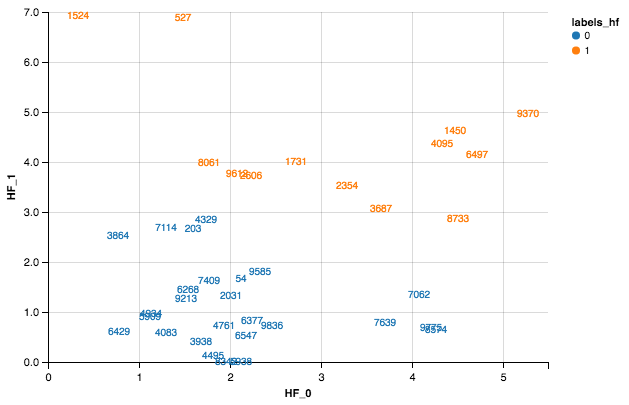

In [68]:

home_fac['home'] = home_fac.index
from altair import Chart
c = Chart(home_fac)
c.mark_text().encode(
    x='HF_0',
    y='HF_1',
    color='labels_hf:N',
    text='home:N',
   
)

In [31]:
pd.crosstab(home_fac['labels-aggregate'], home_fac['labels-hf'])

labels-hf,0,1
labels-aggregate,,
0,15,10
1,6,8


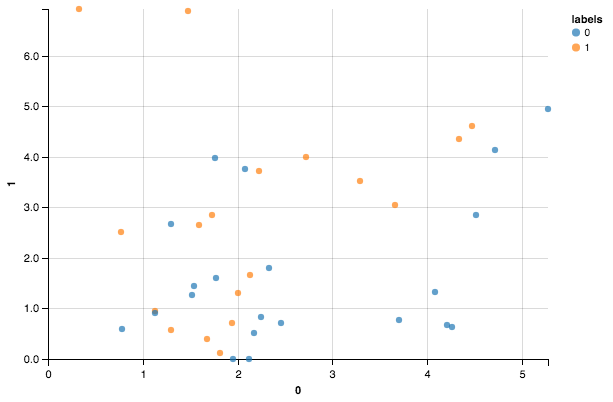

In [131]:
labels_2, centroids_2, X_hat = kmeans_missing(home_fac, n_clusters=2)
home_fac['labels'] = labels_2
home_fac['home'] = home_fac.index
from altair import Chart
c = Chart(home_fac)
c.mark_circle().encode(
    x='0',
    y='1',
    color='labels:N',
    text='home:N',
   
)